# ccdt_afig_baselineHFA_byClus

### This notebook generates figures for

Figure 2:  Widespread neural activity during the foreperiod delay encodes anticipatory bias
a) HFA methods
b) electrode distribution across intrinsic brain networks
c) delay period elevation encodes subject by subject variability in anticipatory bias (across regions)
d) scatter plot in FP network
e) timing in FP network

built from ccdt_explore_pow3d


Ashwin G. Ramayya  (ashwinramayya@gmail.com) 10/16/2023



In [6]:
#import packages
import numpy as np # numpy
import pandas as pd # pandas
import mne
import pickle
import os
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,spatial
import numpy.random as rand
import pycircstat as circ
import fooof as ff
import tensorpac as tp
import ccdt_func as cc
import pingouin as pg
#FDR correction
from statsmodels.stats.multitest import multipletests as FDR

# plotting
import matplotlib
#matplotlib.use('macosx')
#matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['font.size'] = 20
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt 

# create fig dir
fig_dir = os.getcwd()+'/figs/afig_r1/'
if os.path.exists(fig_dir)==False:
     os.mkdir(fig_dir)
        
def save_fig(fname,do_tight = True):
    ax = plt.gca()
    if do_tight == True:
        plt.tight_layout()
    plt.savefig(fname = fig_dir+fname+'.pdf')
    #plt.savefig(fname = fig_dir+fname+'.png')


#### Here, we load processed data. load a Collection object, define parameters for power analysis, Load power data, We remove bad electrodes; 


Important Note To run 3d power:
- Default parameters  uses a wave_freq range of (70, 200) and 5 frequencies when computing power
- To compute power across other frequencies, we need to provide a new params dictionary
- This will create a separate folder for analyses (this is how each paramsdictionary will get tagged
- Then for subsequent analyses (like relating to brain regions or clusters, will need to develop methods to index these power data using independent boolans, rather than cluster electrode. May be easy to update plotPow3d to allow us to provide a boolean

In [7]:
%%capture 
paramsDict={}
paramsDict['wave_frange'] = (2,200)
paramsDict['wave_number_of_freq']=50
paramsDict['tmin_ms'] = -1000#-1000# # Rest interval starts at -2000 (it is the earliest predictive cue)
paramsDict['tmax_ms'] =2500 #(+1500 gets you to color change, + 2500 gets you to the end of the response interval)


# get collection to filter subjCollection (for popStats)
Cpow = cc.Collection(collection_lbl='all',paramsDict=paramsDict)


# calculate 3d power for long delay trials ()
Cpow.getPow_3d(pow_evType='FIX_START',pow_evQuery = 'error==0&fastResponse==0&badTrial==0&delay==1500', do_zscore = True,apply_time_bins=True,time_bin_size_ms=50)


# filter to only include good electrodes (manually done above) and specific regions
goodElecsIdx = np.array(Cpow.isBadElectrode_list)==False

# option to only filter good electrodes
Cpow.filterElectrodes(filtE_bool= goodElecsIdx)



## Collecting data

Here we collect our standard set of processed data (that we use in rtClus, clusHFA,popHFA) that will allow us to index the power data by subject, anatomy, RT cluster, etc. Not we exclude bad electrodes from these data. Thus, there should be a one to one correspondence between power data and HFA data. 

In [5]:
%%capture 
# Collect Group taskstats Data
C = cc.Collection(collection_lbl='all')

C.doTaskStats_2d(pow_frange_lbl = 'HFA',
pow_method = 'wave',
pow_evQuery = 'error==0&fastResponse==0&badTrial==0',
do_zscore = True,
apply_gauss_smoothing = True,
gauss_sd_scaling = 0.075,
apply_time_bins=False,num_iters=1000,
time_bin_size_ms=100,overwriteFlag =False,feat_list_beh=['zrrtStoch'])

# get bool masks (for overall )
#ret_dict = C.groupElectrodesByTaskStats(print_flag=False)

# filter to only include good electrodes
C.filterElectrodes(filtE_bool= np.array(C.isBadElectrode_list)==False)


# Cluster Eelectrodes
feat_option = 'selectivity_taskRt'

C.clusterElectrodesByTaskStats(feat_option=feat_option,binarize_stats=True)

# get target-locked pow
C.getPow_2d(pow_evType='FIX_START',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'error==0&fastResponse==0&badTrial==0',paramsDict = {},do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50,overwriteFlag=False)

# create a shallow copy and get response-locked power
import copy
C2 = copy.copy(C)
C2.getPow_2d(pow_evType='RESPONSE',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'error==0&fastResponse==0&badTrial==0',paramsDict = {},do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50,overwriteFlag=False)

# get errors
C_err = copy.copy(C)
C_err.getPow_2d(pow_evType='FIX_START',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'RT<0&delay==1500',paramsDict = {},do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50,overwriteFlag=False)

# get errors
C2_err = copy.copy(C)
C2_err.getPow_2d(pow_evType='RESPONSE',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'RT<0&delay==1500',paramsDict = {},do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50,overwriteFlag=False)


# get ret_dict (to identify subgroups of electrodes)
ret_dict = C.groupElectrodesByTaskStats()

# get anatDf
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow',atlas='default');
anatDf_yeo,roiList_yeo = C.getAnatDf(ret_idx=None,cmap='rainbow',atlas='yeo');
anatDf_ant,roiList_ant = C.getAnatDf(ret_idx=None,cmap='rainbow',atlas='anticipationrois');

# get behavioral data (we will add columns to this dataframe throughout this notebook)
beh_df = C.getBehXSubj(evQuery='error==0&fastResponse==0', later_model_type = 'distance',\
                      later_model_strategy = 'DynamicBaseline')


UnboundLocalError: cannot access local variable 'roi' where it is not associated with a value

In [4]:
# DEFINE SUBFUNCTIONS
def doCorr_local(x,y,use_spearman=False):
    #remove nans and inf
    rm_bool = (np.isnan(x)) | (np.isnan(y)) | (np.isinf(x)) | (np.isinf(y)) 
    x = x[rm_bool==False]
    y = y[rm_bool==False]
    if use_spearman == True:
        rval,pval = stats.spearmanr(x,y)
    else:
        rval,pval = stats.pearsonr(x,y)
    return rval,pval
def getMeanPow_xSubj(ret_idx =None, frange=(70,200),trange=(1000,1500),roi=None,atlas='default',baseline_correct=False,trange_bl=(-500,0)):
    
    subj_list = list(beh_df['subj'].to_numpy())
    
    # parse ret_idx input
    if ret_idx is None:
        ret_idx = np.ones(len(C.uElbl_list)).astype('bool')
    
 
    f_idx = (Cpow.pow3d_freqs>=frange[0])&(Cpow.pow3d_freqs<=frange[1])
    t_idx = (Cpow.pow3d_xval>=trange[0])&(Cpow.pow3d_xval<=trange[1])
    t_idx_bl = (Cpow.pow3d_xval>=trange_bl[0])&(Cpow.pow3d_xval<=trange_bl[1])
    
    #t_idx = (C.pow_xval>=trange[0])&(C.pow_xval<=trange[1])
    
    mean_pow = np.zeros(len(subj_list))
    mean_pow[:] = np.nan
    
    for s in subj_list:
        
        if roi is None:
            thisSubj_ret_idx = ret_idx&(C.subj_list==s)
        else:
            if atlas == 'default':
                thisSubj_ret_idx = ret_idx&(C.subj_list==s)& (anatDf.eval('roi=="'+roi+'"'))
            elif atlas == 'yeo':
                thisSubj_ret_idx = ret_idx&(C.subj_list==s)& (anatDf_yeo.eval('roi=="'+roi+'"'))
            elif atlas == 'anticipationrois':
                thisSubj_ret_idx = ret_idx&(C.subj_list==s)& (anatDf_ant.eval('roi=="'+roi+'"'))
        
        # get mean pow
        #print((C.powMat[thisSubj_ret_idx,:][:,t_idx]).shape)
        
        #old
        #mean_pow[subj_list.index(s)] = np.nanmean(np.nanmean(C.powMat[thisSubj_ret_idx,:][:,t_idx],axis=1))
        
        #get baseline pow
        baseline_pow = np.nanmean(np.nanmean(np.nanmean(Cpow.pow3d[:,:,thisSubj_ret_idx],axis=2)[f_idx,:],axis=0)[t_idx_bl])
        
        this_mean_pow =  np.nanmean(np.nanmean(np.nanmean(Cpow.pow3d[:,:,thisSubj_ret_idx],axis=2)[f_idx,:],axis=0)[t_idx])
       
        #new
        if baseline_correct == True:
            mean_pow[subj_list.index(s)]  =this_mean_pow-baseline_pow
        else:
            mean_pow[subj_list.index(s)]  =this_mean_pow
            

    return mean_pow

def doCorr_xSubj(beh_var_lbl = None,ret_idx =None, frange=(70,200),trange=(1000,1500),roi=None,atlas='default',use_spearman=False,baseline_correct=True):
    
    mean_pow = getMeanPow_xSubj(ret_idx =ret_idx, frange=frange,trange=trange,roi=roi,atlas=atlas,baseline_correct=baseline_correct);
    
    rval,pval = doCorr_local(x=mean_pow,y=beh_df[beh_var_lbl].to_numpy(),use_spearman = use_spearman)
    nsubj = np.sum(np.isnan(mean_pow)==False)
    
    return rval,pval,nsubj
def doPartialCorr_xSubj(beh_var_lbl = None,b_control = None,ret_idx =None, frange=(70,200),trange=(1000,1500),roi=None,atlas='default',use_spearman=False,baseline_correct=False):
    
    mean_pow = getMeanPow_xSubj(ret_idx =ret_idx, frange=frange,trange=trange,roi=roi,atlas=atlas,baseline_correct=baseline_correct);
    
    bn_dict = {}
    bn_dict['neu'] = mean_pow
    bn_dict['beh'] = beh_df[beh_var_lbl].to_numpy()
    bn_dict['beh_control'] = beh_df[b_control].to_numpy()
    
    #convert to dataframe
    bn_df = pd.DataFrame.from_dict(bn_dict)
    
    corrstats = pg.partial_corr(data = bn_df, x='neu',y ='beh',covar = 'beh_control',method='pearson')
    rval = corrstats['r'].to_numpy()[0]
    pval = corrstats['p-val'].to_numpy()[0]
    nsubj = len(mean_pow)
        
    return rval,pval



def fdr_wrapper(p_list,lbls_list):
    # make sure there are no nans
    p_list = np.array(p_list)
    p_list[np.isnan(p_list)]=1
    reject,pvals_corrected,AS,AB =  FDR(pvals = p_list, alpha = 0.05,method = 'fdr_bh')
    return pvals_corrected

    """
    print('\n')
    print('FDR-corrected p values')
    print(np.hstack((np.array(lbls_list).squeeze()[:,np.newaxis],\
                     np.array(np.round(pvals_corrected,3)).squeeze()[:,np.newaxis])))
    """    
def plotXSubj_scatter(beh_var_lbl = 'rtDiff_mean',frange=(70,200),trange=(750,200),roi = None,\
                      figsize=(5,5),use_spearman=True,plot_flag=True,atlas = 'default',msize=None):

    subj_list = list(beh_df.sort_values(beh_var_lbl,ascending=True)['subj'].to_numpy())

    # identify freq range and time range of interest
    #frange = (4,8) # range of freqencies to aggregate power
    #trange = (750,1500)  # range of time windows to aggregate power

    f_idx = (Cpow.pow3d_freqs>=frange[0])&(Cpow.pow3d_freqs<=frange[1])
    t_idx = (Cpow.pow3d_xval>=trange[0])&(Cpow.pow3d_xval<=trange[1])

    # behavioral neural (bn) dataframe to hold data. starts as a list
    bn_df = []


    for s in subj_list:
        
        if roi is None:
            ret_idx = (Cpow.subj_list==s)
        else:
            if atlas == 'default':
                ret_idx = (Cpow.subj_list==s)& (anatDf.eval('roi=="'+roi+'"'))
            elif atlas == 'yeo':
                ret_idx = (Cpow.subj_list==s)& (anatDf_yeo.eval('roi=="'+roi+'"'))
                
        #calc mean pow
        meanpow = np.nanmean(np.nanmean(np.nanmean(Cpow.pow3d[:,:,ret_idx],axis=2)[f_idx,:],axis=0)[t_idx])

        # dictionary for this subject
        bn_dict = {}
        bn_dict['subj'] = s
        bn_dict['beh'] = beh_df.loc[s][beh_var_lbl]
        bn_dict['neu'] = meanpow

        # append to list
        bn_df.append(bn_dict)
    bn_df = pd.DataFrame(bn_df,index=subj_list)

    # plot correlatoin
    if plot_flag == True:
        Cpow.plot_scatter(bn_df['beh'],bn_df['neu'],use_spearman=use_spearman,figsize=figsize,s=msize);
        plt.gca().set_xlabel(beh_var_lbl)
        plt.gca().set_ylabel('f'+str(frange)+'\n-t'+str(trange))
        plt.gca().set_title(str(roi)+': '+plt.gca().get_title(),fontsize=10)
        
    
    # compute correlation
    x = bn_df['beh']
    y = bn_df['neu']
    
    rval,pval = doCorr_local(x,y,use_spearman=use_spearman)
    
    return rval,pval,bn_df
 
def doPartialCorrXSubj(ret_idx = None,beh_var_lbl = 'paramsDiff_D',beh_control = 'paramsDiff_P',frange=(70,200),trange=(750,200),roi = None,\
                      figsize=(5,5),use_spearman=True,plot_flag=True,atlas = 'default'):

    subj_list = list(beh_df.sort_values(beh_var_lbl,ascending=True)['subj'].to_numpy())

    # parse ret_idx input
    if ret_idx is None:
        ret_idx = np.ones(len(C.uElbl_list)).astype('bool')
    # identify freq range and time range of interest
    #frange = (4,8) # range of freqencies to aggregate power
    #trange = (750,1500)  # range of time windows to aggregate power

    f_idx = (Cpow.pow3d_freqs>=frange[0])&(Cpow.pow3d_freqs<=frange[1])
    t_idx = (Cpow.pow3d_xval>=trange[0])&(Cpow.pow3d_xval<=trange[1])

    # behavioral neural (bn) dataframe to hold data. starts as a list
    bn_df = []


    for s in subj_list:
        
        if roi is None:
            this_ret_idx = ret_idx&(Cpow.subj_list==s)
        else:
            if atlas == 'default':
                this_ret_idx = ret_idx&(Cpow.subj_list==s)& (anatDf.eval('roi=="'+roi+'"'))
            elif atlas == 'yeo':
                this_ret_idx = ret_idx&(Cpow.subj_list==s)& (anatDf_yeo.eval('roi=="'+roi+'"'))
            elif atlas == 'anticipationrois':
                this_ret_idx = ret_idx&(Cpow.subj_list==s)& (anatDf_ant.eval('roi=="'+roi+'"'))
                
        #calc mean pow
        meanpow = np.nanmean(np.nanmean(np.nanmean(Cpow.pow3d[:,:,this_ret_idx],axis=2)[f_idx,:],axis=0)[t_idx])

        # dictionary for this subject
        bn_dict = {}
        bn_dict['subj'] = s
        bn_dict['beh'] = beh_df.loc[s][beh_var_lbl]
        bn_dict['neu'] = meanpow
        bn_dict['beh_control'] = beh_df.loc[s][beh_control]

        # append to list
        bn_df.append(bn_dict)
    bn_df = pd.DataFrame(bn_df,index=subj_list)

    # plot correlatoin
    #if plot_flag == True:
    #    Cpow.plot_scatter(bn_df['beh'],bn_df['neu'],use_spearman=use_spearman,figsize=figsize);
    #    plt.gca().set_xlabel(beh_var_lbl)
    #    plt.gca().set_ylabel('f'+str(frange)+'\n-t'+str(trange))
    #    plt.gca().set_title(str(roi)+': '+plt.gca().get_title(),fontsize=10)
        
    
    # compute correlation
    corrstats = pg.partial_corr(data = bn_df, x='neu',y ='beh',covar = 'beh_control',method='pearson')
    rval = corrstats['r']
    pval = corrstats['p-val']
    nsubj = np.sum(np.isnan(bn_df['neu'].to_numpy()==False))
    
    return rval,pval,bn_df,nsubj

def plot_xSubjCorr_region_specificity(ret_idx = None,beh_var_lbl=None,frange=(70,200),trange=None,use_spearman=False,figsize=None,plot_flag=False,atlas='default',min_subj = 5, min_elec=50,\
                                     doPartialCorr=False, beh_control = 'rtDiff_mean'):
    #container
    if atlas == 'default':
        this_roi_list = roiList
    elif atlas == 'yeo':
        this_roi_list = roiList_yeo
    elif atlas == 'anticipationrois':
        this_roi_list = roiList_ant
    
    rval_list = np.zeros(len(this_roi_list))
    pval_list = np.zeros(len(this_roi_list))
    nsubj_list = np.zeros(len(this_roi_list))
    
    
    for r in this_roi_list:    
        roi = r # 'Prefrontal' #( regional control)
        if doPartialCorr == True:
            rval,pval,bn_df,nsubj = doPartialCorrXSubj(beh_var_lbl = beh_var_lbl,\
                  frange=frange,trange=trange,roi = roi,\
                   beh_control = beh_control, \
                 figsize= figsize,use_spearman=use_spearman,\
                   plot_flag=plot_flag,atlas=atlas)
        else:
            rval,pval,nsubj = doCorr_xSubj(beh_var_lbl=beh_var_lbl,ret_idx =ret_idx,frange=frange,trange=trange,roi=roi,atlas=atlas,use_spearman=use_spearman)
        
        
        rval_list[this_roi_list.index(r)] = rval
        pval_list[this_roi_list.index(r)] = pval
        nsubj_list[this_roi_list.index(r)] = nsubj

    f,ax = plt.subplots(1,1,figsize=(5,3))
    plt.bar(np.arange(0,len(this_roi_list)),rval_list,edgecolor = 'k',color = '0.5',tick_label = this_roi_list);
    plt.gca().set_xlim(-0.5,len(this_roi_list)+0.5)
    plt.xticks(rotation=90,fontsize=12)

    pvals_corrected = fdr_wrapper(pval_list,this_roi_list)
    
    # indicate significant values
    p_thresh = 0.05
    for i in np.arange(0,len(this_roi_list)):
        if pvals_corrected[i]<=p_thresh:
            plt.text(i-.5,rval_list[i],'***')
        elif pval_list[i]<=p_thresh:
            plt.text(i,rval_list[i],'*') 

            
    plot_dict = {}
    plot_dict['r'] = np.array(rval_list)
    plot_dict['p'] = np.array(pval_list)
    plot_dict['p_corrected'] = np.array(pvals_corrected)
    plot_dict['lbls'] = np.array(this_roi_list)
    plot_dict['nsubj'] = np.array(nsubj_list)
    
    return plot_dict
def plot_xSubjCorr_timeSpecificity(ret_idx = None, beh_var_lbl=None,frange=(70,200),\
                                   trange_start=-1000,trange_stop=1500,trange_step=200,t_size=500,\
                                   use_spearman=False,figsize=None,plot_flag=False,\
                                   roi=None,atlas='default',vline_list=[0,1500], doPartialCorr = False,\
                                   beh_control = 'rtDiff_mean',):
    
        
    trange_list = list(np.arange(trange_start,trange_stop,trange_step))

    rval_list = np.zeros(len(trange_list))
    rval_list[:] = np.nan
    
    t_mean_list = np.zeros(len(trange_list))
    t_mean_list[:] = np.nan

    
    for t in trange_list: 
        if doPartialCorr == True:
            rval,pval,bn_df = doPartialCorrXSubj(ret_idx=ret_idx,beh_var_lbl = beh_var_lbl,\
                  frange=frange,trange=(t,t+t_size),roi = roi,\
                   beh_control = beh_control, \
                 figsize= figsize,use_spearman=use_spearman,\
                   plot_flag=plot_flag,atlas=atlas)
        else:
            rval,pval = doCorr_xSubj(beh_var_lbl=beh_var_lbl,ret_idx =ret_idx,frange=frange,trange=(t,t+t_size),\
                                 roi=roi,atlas=atlas,use_spearman=use_spearman)
        
        rval_list[trange_list.index(t)] = rval        
        t_mean_list[trange_list.index(t)] = np.nanmean((t,t+t_size)).astype('int')
        
    
    f,ax = plt.subplots(1,1,figsize=(5,3))

    # plot it
    ax.plot(t_mean_list,rval_list,color='0.5')
    plt.gca().set_ylim((-1,1))

    # plot vlines
    for v in vline_list:
        ax.vlines(x=t_mean_list[np.argmin(np.abs(t_mean_list-v))],
                  ymin=ax.get_ylim()[0],
                  ymax=ax.get_ylim()[1],
                  linestyles='--',color='0.5',alpha=0.5)
    plt.gca().set_xlabel('Time from target onset (ms)')
    plt.gca().set_ylabel('$r$')
    
    # plot peak
    plt.gca().vlines(t_mean_list[np.argmax(np.abs(rval_list))],plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle='--',color='r',alpha=0.5)
    tStart = trange_list[np.argmax(np.abs(rval_list))]
    plt.gca().set_title(str(tStart)+'-'+str(tStart+t_size))

    
    
    
def plotXSubj_timeCourse(clus_ret_idx = None,beh_var_lbl = 'paramsDiff_B',ascending_bool=True,\
                         frange=(70,200),trange=(-1000,2500),roi = None,\
                         atlas='default',figsize=(5,5),apply_gauss_smoothing = True,\
                         gauss_sigma=2,vline_list=[0,1500], trange_interest=(1000,1600)):
    """ This function plots a time course of mean power\
    within a certain frequency range on a subject by subject basis, \
    it colors each time course based on a behavioral effect"""
        
    subj_list = list(beh_df.sort_values(beh_var_lbl,ascending=ascending_bool)['subj'].to_numpy())
    
    #print(subj_list)

    f_idx = (Cpow.pow3d_freqs>=frange[0])&(Cpow.pow3d_freqs<=frange[1])
    t_idx = (Cpow.pow3d_xval>=trange[0])&(Cpow.pow3d_xval<=trange[1])

    # container to hold mean power values
    mean_pow = np.zeros((len(subj_list),np.sum(t_idx)))

    # set a color range

    # initialize figure
    f,ax = plt.subplots(1,1)

    for s in subj_list:

        if roi is None:
            ret_idx = (Cpow.subj_list==s)&clus_ret_idx
        else:
            if atlas == 'default':
                ret_idx = (Cpow.subj_list==s)& (anatDf.eval('roi=="'+roi+'"'))&clus_ret_idx
            elif atlas == 'yeo':
                ret_idx = (Cpow.subj_list==s)& (anatDf_yeo.eval('roi=="'+roi+'"'))&clus_ret_idx

        #calc mean pow
        mean_pow[subj_list.index(s),:] = np.nanmean(np.nanmean(Cpow.pow3d[:,:,ret_idx],axis=2)[f_idx,:],axis=0)[t_idx]


        # apply smoothing
        if apply_gauss_smoothing == True:
            mean_pow_vec = ndimage.filters.gaussian_filter1d(mean_pow[subj_list.index(s),:],sigma=gauss_sigma)

        # plot it
        ax.plot(Cpow.pow3d_xval[t_idx],mean_pow_vec,color='r',alpha=(subj_list.index(s)/len(subj_list)))
    

        
    # plot vlines
    for v in vline_list:
        #print(Cpow.pow3d_xval[t_idx][np.argmin(np.abs(Cpow.pow3d_xval[t_idx]-v))])
        ax.vlines(x=Cpow.pow3d_xval[t_idx][np.argmin(np.abs(Cpow.pow3d_xval[t_idx]-v))],
                  ymin=ax.get_ylim()[0],
                  ymax=ax.get_ylim()[1],
                  linestyles='--',color='0.5',alpha=0.5)
    plt.gca().set_xlabel('Time from target onset (ms)')
    plt.gca().set_ylabel('f'+str(frange))
        
    
    # color time window of interest
    #get xcoords of interest
    ax.fill_betweenx(plt.gca().get_ylim(),(trange_interest[0],trange_interest[0])\
                     ,(trange_interest[1],trange_interest[1]),color='0.5',alpha=0.2)

    plt.gca().axis('tight')

def plot_xSubjCorr_cluster_specificity(cut_level = None, beh_var_lbl=None,frange=(70,200),trange=None,use_spearman=False,figsize=None,plot_flag=False,roi = None, atlas='default',min_subj = 5, min_elec=50,baseline_correct=False):

    rval_list = []
    pval_list = []
    lbl_list = []
    
    
    for i in np.arange(0,cut_level+1):
        clusid=i

        # ret_idx for this cluster
        ret_idx = C.clus_cut_tree[:,cut_level]==clusid
        
        # skip this cluster if we dont have enough subjects or electrodes 
        n_subj = np.count_nonzero(C.collapseBySubj_1d(ret_idx))
        
        if (n_subj<min_subj) | (np.count_nonzero(ret_idx)<min_elec):
            continue
              
        # do partial corr across subjects        
        #print(roi,str(i),str(n_subj))
        rval,pval = doCorr_xSubj(beh_var_lbl=beh_var_lbl,ret_idx =ret_idx,frange=frange,trange=trange,roi=roi,atlas=atlas,use_spearman=use_spearman, baseline_correct=baseline_correct)
                
        # collect r val and pval
        rval_list.append(rval)
        pval_list.append(pval)
        lbl_list.append(str(i))
        
    # plot 
    f,ax = plt.subplots(1,1,figsize=(5,3))
    plt.bar(np.arange(0,len(lbl_list)),rval_list,edgecolor = 'k',color = '0.5',tick_label = lbl_list);
    plt.gca().set_xlim(-0.5,len(lbl_list)+0.5)
    plt.xticks(rotation=90,fontsize=12)
    ax.set_ylim(-1,1)

    pvals_corrected = fdr_wrapper(pval_list,lbl_list)
    
    # indicate significant values
    p_thresh = 0.05
    for i in np.arange(0,len(lbl_list)):
        if pvals_corrected[i]<=p_thresh:
            plt.text(i-.5,rval_list[i],'***')
        elif pval_list[i]<=p_thresh:
            plt.text(i,rval_list[i],'*')  
            
    plot_dict = {}
    plot_dict['r'] = np.array(rval_list)
    plot_dict['p'] = np.array(pval_list)
    plot_dict['p_corrected'] = np.array(pvals_corrected)
    plot_dict['lbls'] = np.array(lbl_list)
    
    return plot_dict
            
def plot_xSubjPartialCorr_cluster_specificity(cut_level = None, beh_var_lbl=None,b_control = None,frange=(70,200),trange=None,use_spearman=False,figsize=None,plot_flag=False,roi = None, atlas='default',min_subj = 5, min_elec=50,baseline_correct=False):

    rval_list = []
    pval_list = []
    lbl_list = []
    
    
    for i in np.arange(0,cut_level+1):
        clusid=i

        # ret_idx for this cluster
        ret_idx = C.clus_cut_tree[:,cut_level]==clusid
        
        # skip this cluster if we dont have enough subjects or electrodes 
        n_subj = np.count_nonzero(C.collapseBySubj_1d(ret_idx))
        
        if (n_subj<min_subj) | (np.count_nonzero(ret_idx)<min_elec):
            continue
              
        # doCorr across subjects
        #print(roi,str(i),str(n_subj))
        rval,pval = doPartialCorr_xSubj(beh_var_lbl=beh_var_lbl,b_control = b_control,ret_idx =ret_idx,trange=trange,roi=roi,atlas=atlas,use_spearman=use_spearman,baseline_correct=baseline_correct)
                
        # collect r val and pval
        rval_list.append(rval)
        pval_list.append(pval)
        lbl_list.append(str(i))
        
    pvals_corrected = fdr_wrapper(pval_list,lbl_list)
    # plot 
    #print(rval_list)
    if plot_flag==True:
        f,ax = plt.subplots(1,1,figsize=(5,3))
        plt.bar(np.arange(0,len(lbl_list)),rval_list,edgecolor = 'k',color = '0.5',tick_label = lbl_list);
        plt.gca().set_xlim(-0.5,len(lbl_list)+0.5)
        plt.xticks(rotation=90,fontsize=12)
        ax.set_ylim(-1,1)

        # indicate significant values
        p_thresh = 0.05
        for i in np.arange(0,len(lbl_list)):
            if pvals_corrected[i]<=p_thresh:
                plt.text(i-.5,rval_list[i],'***')
            elif pval_list[i]<=p_thresh:
                plt.text(i,rval_list[i],'*')  
    plot_dict = {}
    plot_dict['r'] = np.array(rval_list)
    plot_dict['p'] = np.array(pval_list)
    plot_dict['p_corrected'] = np.array(pvals_corrected)
    plot_dict['lbls'] = np.array(lbl_list)
    
    return plot_dict
   
def plot_xSubjCorr_ClusterXRegion_specificity(cut_level = None,beh_var_lbl=None,frange=(70,200),trange=None,use_spearman=False,figsize=None,plot_flag=False,atlas='default',min_subj = 5, min_elec=50):
    #container
    
    if atlas == 'default':
        this_roi_list = roiList
    elif atlas == 'yeo':
        this_roi_list = roiList_yeo
    
    rval_list = []
    pval_list = []
    lbl_list = []
    
    for clusid in np.arange(0,cut_level+1):
        ret_idx_clus = C.clus_cut_tree[:,cut_level]==clusid

        for r in this_roi_list:    

            if atlas == 'default':
                ret_idx_anat = anatDf.eval('roi=="'+r+'"')
            elif atlas == 'yeo':
                ret_idx_anat = anatDf_yeo.eval('roi=="'+r+'"')
                
            # ret_idx based on both clustters and anatomy
            ret_idx = ret_idx_clus&ret_idx_anat
        
                
            # make sure we have enough data
            n_subj = np.count_nonzero(C.collapseBySubj_1d(ret_idx))

            if (n_subj<min_subj) | (np.count_nonzero(ret_idx)<min_elec):
                continue
              
            # Calculate correlation
            # roi is set to None because we already accounted for anatomical filter with ret_idx
            rval,pval = doCorr_xSubj(beh_var_lbl=beh_var_lbl,ret_idx =ret_idx,trange=trange,roi=None,atlas=atlas,use_spearman=use_spearman)


            rval_list.append(rval)
            pval_list.append(pval)
            lbl_list.append(str(clusid)+'-'+r)
            

    f,ax = plt.subplots(1,1,figsize=figsize)
    plt.bar(np.arange(0,len(lbl_list)),rval_list,edgecolor = 'k',color = '0.5',tick_label = lbl_list);
    plt.gca().set_xlim(-0.5,len(lbl_list)+0.5)
    plt.xticks(rotation=90,fontsize=12)

    pvals_corrected = fdr_wrapper(pval_list,lbl_list)
    
    # indicate significant values
    p_thresh = 0.05
    for i in np.arange(0,len(lbl_list)):
        if pvals_corrected[i]<=p_thresh:
            plt.text(i-.5,rval_list[i],'***')
        elif pval_list[i]<=p_thresh:
            plt.text(i,rval_list[i],'*')  
    return lbl_list, pvals_corrected
            
def plotActFunc(ret_idx,yL = (-1,2.75),beh_feat = 'zrrt',lbl = None,binByRT=True,show_false_alarms = False,delays_list=[500,1500],alphas_list = [0.75,0.75]):
    """This function plots an average activation function for a group of electrodes"""
    #[] return mean power for a specified time range
    
    # calc num subj
    #n_subj = np.count_nonzero(C.collapseBySubj_1d(ret_idx))
    #print('\n')
    #print(lbl,'n elec = ', np.count_nonzero(ret_idx), 'n subj = ',n_subj)

    # create figure
    figsize=(10,5)
    f = plt.figure(figsize=figsize,facecolor='w') 


    # create subplots and axes
    gs = f.add_gridspec(nrows=2,ncols=6)
    ax_fix = f.add_subplot(gs[:,0:4])
    ax_resp = f.add_subplot(gs[:,4:])
    

    # plot targ-locked power
    C.evalClus_powByRT2d(ax = ax_fix,ret_idx = ret_idx,figsize=(7,5),yL=yL,binByRT=binByRT,delays_list=delays_list,alpha = alphas_list,add_vline=False)
    # plot targ error
    if show_false_alarms == True:
        C_err.evalClus_powByRT2d(ax = ax_fix,ret_idx = ret_idx,figsize=(7,5),yL=yL,binByRT=False,color = '0.5',alpha=0.4,add_vline=False)
    ax_fix.legend().remove()
    ax_fix.set_xlabel('Time from target (ms)',fontsize=20)
    ax_fix.set_title('')


    # plot resp-locked power
    C2.evalClus_powByRT2d(ax=ax_resp,ret_idx = ret_idx,xL_ms=(-1000,1000),figsize=(5,5),yL=yL,binByRT=binByRT,delays_list=delays_list,alpha = alphas_list)
    # plot resp error
    if show_false_alarms == True:
        C2_err.evalClus_powByRT2d(ax = ax_resp,ret_idx = ret_idx,figsize=(7,5),yL=yL,binByRT=False,xL_ms=(-1000,1000),color = '0.5',alpha=0.4)
    ax_resp.legend().remove()
    ax_resp.set_title('')
    
    return ax_fix, ax_resp
    
def plotActFunc_bySubj(ret_idx=None,beh_var_lbl='rtDiff_mean',ascending_bool = True,\
                      roi = None,atlas='default',yL = (-1,2.75),beh_feat = 'zrrt',\
                       lbl = None,binByRT=True,show_false_alarms = False,\
                       delays_list=[500,1500],alphas_list = [0.75,0.75]):
    """ This function loops through subjects arranged\
    based on a particular behavior and plots aggregate activation functions, \
    only focusing on a particular group of electrodes for each subject (ret_idx).
    Inputs:
    'roi' and 'atlas' allows you to only focus on a particular a region"""
    
    # get subj_list
    subj_list = list(beh_df.sort_values(beh_var_lbl,ascending=ascending_bool)['subj'].to_numpy())
    
    # parse ret_idx input
    if ret_idx is None:
        ret_idx = np.ones(len(C.uElbl_list)).astype('bool')
    
    # parse roi input
    for s in subj_list:
       

        if roi is None:
            thisSubj_ret_idx = ret_idx&(C.subj_list==s)
        else:
            if atlas == 'default':
                thisSubj_ret_idx = ret_idx&(C.subj_list==s)& (anatDf.eval('roi=="'+roi+'"'))
            elif atlas == 'yeo':
                thisSubj_ret_idx = ret_idx&(C.subj_list==s)& (anatDf_yeo.eval('roi=="'+roi+'"'))

        #plot activation function
        plotActFunc(ret_idx=thisSubj_ret_idx,yL = yL,beh_feat = beh_feat,\
                    lbl = lbl,binByRT=binByRT,show_false_alarms = show_false_alarms,\
                    delays_list=delays_list,alphas_list = alphas_list)
        print(s,beh_df.loc[s][beh_var_lbl])



def get_clus_cut_level(num_levels_to_test = 30,min_subj = 5, min_elec=50):
    def get_num_generalized_clusters(cut_level,min_subj = 5, min_elec=50):
        #This function will compute how many clusters meet the miminum subject and electrode criteria for a given cluster level    clusid=-1

        clusid = -1
        num_clus = 0
        for i in np.arange(-1,cut_level):
            clusid+=1

            # ret_idx
            ret_idx = C.clus_cut_tree[:,cut_level]==clusid

            # calc num subj
            n_subj = np.count_nonzero(C.collapseBySubj_1d(ret_idx))

            if (n_subj>=min_subj) & (np.count_nonzero(ret_idx)>=min_elec):
                num_clus+=1
        return num_clus

    # plot number of "reproducible" clusters as a function of cluster level
    cut_levels_to_test = np.arange(0,num_levels_to_test,1)
    num_clus_by_level = np.zeros(len(cut_levels_to_test))
    count=-1
    for cut_level in cut_levels_to_test:
        count+=1
        num_clus_by_level[count] = get_num_generalized_clusters(cut_level = cut_level,min_subj = min_subj, min_elec=min_elec)
        #print(cut_level)

    cut_level = cut_levels_to_test[np.argmax(num_clus_by_level)]
    print('cut level = ',cut_level) 

    return cut_level, cut_levels_to_test,num_clus_by_level

# [] plot time course by subj (same plot) (fill in between) 
# [] plot time course of correlation to find peak value

# get number of clusters
cut_level,cut_levels_to_test,num_clus_by_level = \
get_clus_cut_level(num_levels_to_test = 10,min_subj = 23, min_elec=200) 
    

cut level =  5


### Delay-interval HFA  vs. RT diff (~expectation)

In [20]:
plot_dict1

{'r': array([-0.26442086,  0.09924282,  0.21443425,  0.10991944,  0.15502875,
         0.07390351,  0.84242797, -0.13590136]),
 'p': array([0.38265732, 0.83234861, 0.32583734, 0.89008056, 0.56644353,
        0.81944604, 0.36225109, 0.67365545]),
 'p_corrected': array([0.89008056, 0.89008056, 0.89008056, 0.89008056, 0.89008056,
        0.89008056, 0.89008056, 0.89008056]),
 'lbls': array(['STG', 'InsulaPost', 'OtherRegions', 'CingulateMid', 'InsulaAnt',
        'CingulateDorsal', 'SMA', 'IFG'], dtype='<U15'),
 'nsubj': array([13.,  7., 23.,  4., 16., 12.,  3., 12.])}

In [5]:
min_subj = 23
min_elec = 200
doPartialCorr = True
# loop through RT clusters
frange = (70,200)
trange = (-250,1450)
roi = None
atlas='default'
baseline_correct= False
lbl = atlas
#beh_var_lbl1 = 'paramsDiff_P'
#beh_var_lbl2 = 'paramsDiff_D'


beh_var_lbl1 = 'rtDiff_mean'
beh_var_lbl2 = 'error_diff'


if doPartialCorr == True:   
    
    plot_dict1 =  plot_xSubjCorr_region_specificity(ret_idx = None,beh_var_lbl=beh_var_lbl1,frange=frange,trange=trange,use_spearman=False,figsize=(5,5),plot_flag=True,atlas=atlas,min_subj = min_subj, min_elec=min_elec,\
                                     doPartialCorr=False, beh_control = beh_var_lbl2)
    
    


    plot_dict2 =  plot_xSubjCorr_region_specificity(ret_idx = None,beh_var_lbl=beh_var_lbl2,frange=frange,trange=trange,use_spearman=False,figsize=(5,5),plot_flag=True,atlas=atlas,min_subj = min_subj, min_elec=min_elec,\
                                     doPartialCorr=False, beh_control = beh_var_lbl1)
    #plt.gca().set_title('$\Delta$'+beh_var_lbl2,fontsize=12)
else:
    print('NOT IMPLEMENTED')
    pass


def plotScatter_local(plot_dict1,plot_dict2,lbl):
    C.plot_scatter(plot_dict1['r'],plot_dict2['r'],\
                   s=400,plotLine=False,color='0.5',text_lbls = plot_dict1['lbls'],alpha=.5)
    
    plt.gca().set_xlim(-1,1)
    plt.gca().set_ylim(-1,1)
    save_fig('2d scatter'+lbl+'-text')
    
    C.plot_scatter(plot_dict1['r'],plot_dict2['r'],\
                   s=400,plotLine=False,color='0.5',text_lbls =None,alpha=0.5)
    
    # plot sig
    p_thresh = 0.05
    sig_idx1 = plot_dict1['p_corrected']<=p_thresh
    sig_idx2 = plot_dict2['p_corrected']<=p_thresh # p_corrected
    
    # plot sig data
    C.plot_scatter(plot_dict1['r'][sig_idx1],plot_dict2['r'][sig_idx1],\
                   ax=plt.gca(),s=400,plotLine=False,color='g',text_lbls = None,alpha= 0.5)   
    C.plot_scatter(plot_dict1['r'][sig_idx2],plot_dict2['r'][sig_idx2],\
                   ax=plt.gca(),s=400,plotLine=False,color='r',text_lbls = None,alpha= 0.5) 
    C.plot_scatter(plot_dict1['r'][sig_idx1&sig_idx2],plot_dict2['r'][sig_idx1&sig_idx2],\
                   ax=plt.gca(),s=400,plotLine=False,color='m',text_lbls = None,alpha= 0.5)   
    
    
    plt.gca().set_xlim(-1,1)
    plt.gca().set_ylim(-1,1)
    plt.gca().hlines(0,plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],linestyle='--',color='0.5',alpha=0.75)
    plt.gca().vlines(0,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle='--',color='0.5',alpha=0.75)

    save_fig('2d scatter'+lbl)
    
plotScatter_local(plot_dict1,plot_dict2,lbl='test')

print(plot_dict1)
print(plot_dict2)

NameError: name 'beh_df' is not defined

In [ ]:



min_subj = 23
min_elec = 200
doPartialCorr = True
# loop through RT clusters
frange = (70,200)
trange = (-250,1450)
roi = None
atlas='anticipationrois'
baseline_correct= False
lbl=atlas

#beh_var_lbl1 = 'paramsDiff_P'
#beh_var_lbl2 = 'paramsDiff_D'


beh_var_lbl1 = 'rtDiff_mean'
beh_var_lbl2 = 'error_diff'





if doPartialCorr == True:   
    
    plot_dict1 =  plot_xSubjCorr_region_specificity(ret_idx = None,beh_var_lbl=beh_var_lbl1,frange=frange,trange=trange,use_spearman=False,figsize=(5,5),plot_flag=True,atlas=atlas,min_subj = min_subj, min_elec=min_elec,\
                                     doPartialCorr=False, beh_control = beh_var_lbl2)
    
    


    plot_dict2 =  plot_xSubjCorr_region_specificity(ret_idx = None,beh_var_lbl=beh_var_lbl2,frange=frange,trange=trange,use_spearman=False,figsize=(5,5),plot_flag=True,atlas=atlas,min_subj = min_subj, min_elec=min_elec,\
                                     doPartialCorr=False, beh_control = beh_var_lbl1)
    #plt.gca().set_title('$\Delta$'+beh_var_lbl2,fontsize=12)
else:
    print('NOT IMPLEMENTED')
    pass


def plotScatter_local(plot_dict1,plot_dict2,lbl,ret_idx):
    C.plot_scatter(plot_dict1['r'][ret_idx],plot_dict2['r'][ret_idx],\
                   s=400,plotLine=False,color='0.5',text_lbls = plot_dict1['lbls'][ret_idx],alpha=.5)
    
    plt.gca().set_xlim(-1,1)
    plt.gca().set_ylim(-1,1)
    save_fig('2d scatter'+lbl+'-text')
    
    C.plot_scatter(plot_dict1['r'][ret_idx],plot_dict2['r'][ret_idx],\
                   s=400,plotLine=False,color='0.5',text_lbls =None,alpha=0.5)
    
    # plot sig
    p_thresh = 0.05
    sig_idx1 = ret_idx&(plot_dict1['p']<=p_thresh)
    sig_idx2 = ret_idx&(plot_dict2['p']<=p_thresh) # p_corrected
    
    # plot sig data
    C.plot_scatter(plot_dict1['r'][sig_idx1],plot_dict2['r'][sig_idx1],\
                   ax=plt.gca(),s=400,plotLine=False,color='g',text_lbls = None,alpha= 0.5)   
    C.plot_scatter(plot_dict1['r'][sig_idx2],plot_dict2['r'][sig_idx2],\
                   ax=plt.gca(),s=400,plotLine=False,color='r',text_lbls = None,alpha= 0.5) 
    C.plot_scatter(plot_dict1['r'][sig_idx1&sig_idx2],plot_dict2['r'][sig_idx1&sig_idx2],\
                   ax=plt.gca(),s=400,plotLine=False,color='m',text_lbls = None,alpha= 0.5)   
    
    
    plt.gca().set_xlim(-1,1)
    plt.gca().set_ylim(-1,1)
    plt.gca().hlines(0,plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],linestyle='--',color='0.5',alpha=0.75)
    plt.gca().vlines(0,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle='--',color='0.5',alpha=0.75)

    save_fig('2d scatter'+lbl)
    
    
# implement min subj here
MINSUBJ=5
ret_idx = (plot_dict1['nsubj']>=MINSUBJ)& (plot_dict2['nsubj']>=MINSUBJ)
print(np.sum(ret_idx))
    
plotScatter_local(plot_dict1,plot_dict2,lbl='ANTROIS',ret_idx=ret_idx)

print(plot_dict1)
print(plot_dict2)

In [ ]:
beh_feat = 'zrrtStoch'
# plot activation functions
for r in roiList:
    print(r)
    ret_idx = (anatDf.eval('roi=="'+r+'"'))
    #1) plot activation function (with peak times overlayed)
    ax_fix,ax_resp =plotActFunc(ret_idx,yL = None,beh_feat = beh_feat,lbl = None,\
        binByRT=False,show_false_alarms = True,delays_list=[1500],alphas_list=[.5,.5])
    plt.gca().set_title(r,fontsize=12)
    save_fig('ActFunc-def-'+r.split('/')[0])

/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13612: RuntimeWarning: Mean of empty slice
  binPowMat = np.nanmean(getattr(self,'binPow_'+str(d)),axis=0).T
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13620: RuntimeWarning: Mean of empty slice
  binPowMat_mean = np.nanmean(binPowMat,axis=0)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13623: RuntimeWarning: Mean of empty slice
  ax.plot(self.pow_xval,np.nanmean(binPowMat,axis=0), color = color,alpha = this_alpha)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


STG
InsulaPost


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13612: RuntimeWarning: Mean of empty slice
  binPowMat = np.nanmean(getattr(self,'binPow_'+str(d)),axis=0).T
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13620: RuntimeWarning: Mean of empty slice
  binPowMat_mean = np.nanmean(binPowMat,axis=0)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13623: RuntimeWarning: Mean of empty slice
  ax.plot(self.pow_xval,np.nanmean(binPowMat,axis=0), color = color,alpha = this_alpha)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13612: RuntimeWarning: Mean of empty slice
  bi

OtherRegions
CingulateMid


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13612: RuntimeWarning: Mean of empty slice
  binPowMat = np.nanmean(getattr(self,'binPow_'+str(d)),axis=0).T
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13620: RuntimeWarning: Mean of empty slice
  binPowMat_mean = np.nanmean(binPowMat,axis=0)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13623: RuntimeWarning: Mean of empty slice
  ax.plot(self.pow_xval,np.nanmean(binPowMat,axis=0), color = color,alpha = this_alpha)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13612: RuntimeWarning: Mean of empty slice
  bi

InsulaAnt
CingulateDorsal


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13612: RuntimeWarning: Mean of empty slice
  binPowMat = np.nanmean(getattr(self,'binPow_'+str(d)),axis=0).T
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13620: RuntimeWarning: Mean of empty slice
  binPowMat_mean = np.nanmean(binPowMat,axis=0)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13623: RuntimeWarning: Mean of empty slice
  ax.plot(self.pow_xval,np.nanmean(binPowMat,axis=0), color = color,alpha = this_alpha)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13612: RuntimeWarning: Mean of empty slice
  bi

SMA
IFG


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13612: RuntimeWarning: Mean of empty slice
  binPowMat = np.nanmean(getattr(self,'binPow_'+str(d)),axis=0).T
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13620: RuntimeWarning: Mean of empty slice
  binPowMat_mean = np.nanmean(binPowMat,axis=0)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13623: RuntimeWarning: Mean of empty slice
  ax.plot(self.pow_xval,np.nanmean(binPowMat,axis=0), color = color,alpha = this_alpha)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


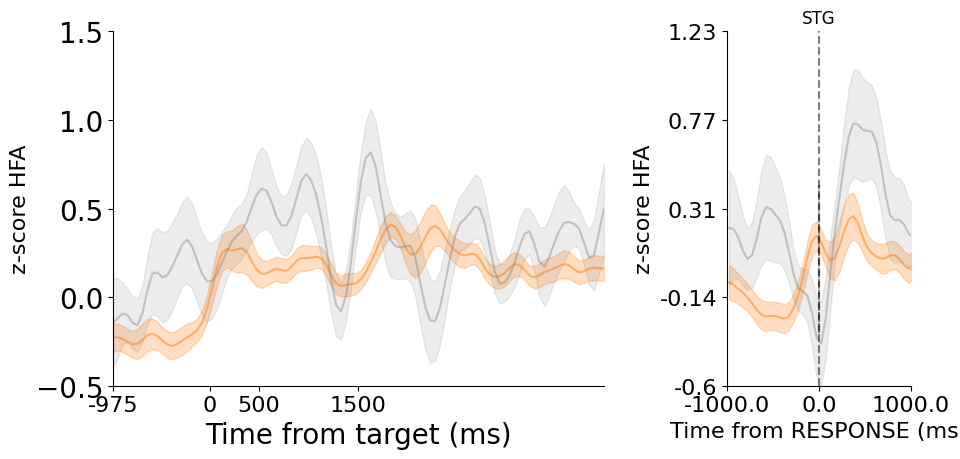

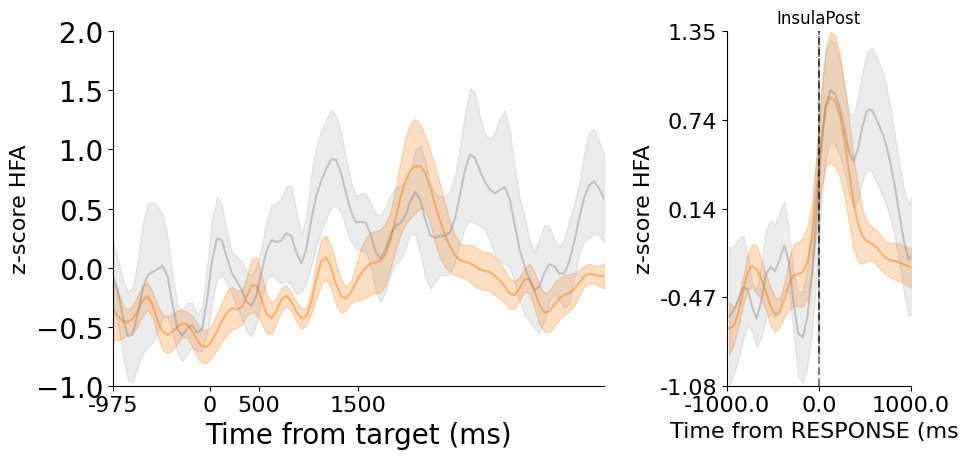

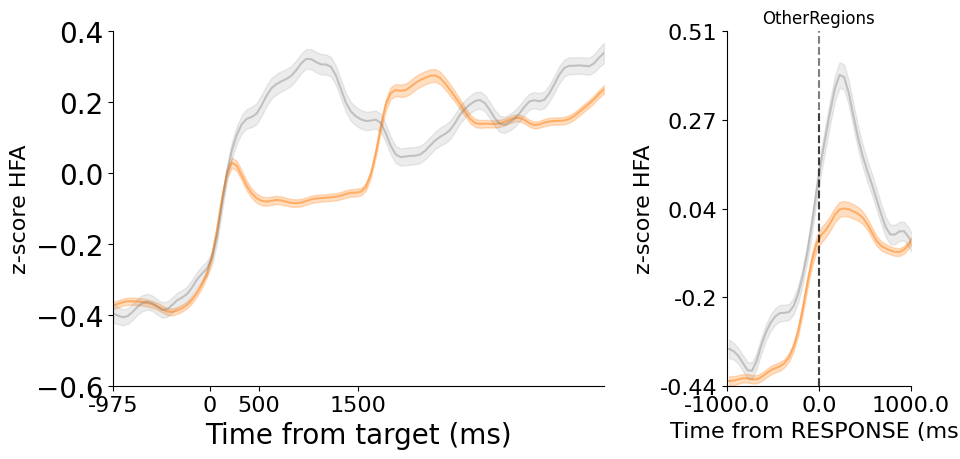

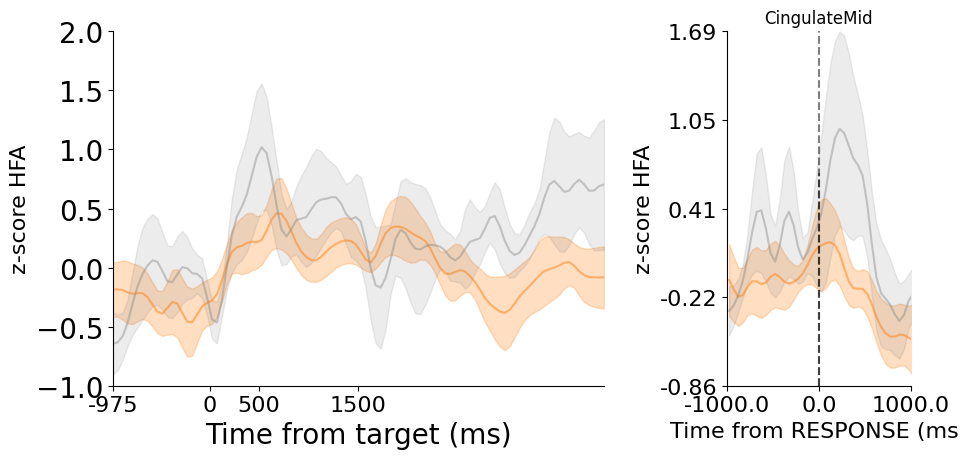

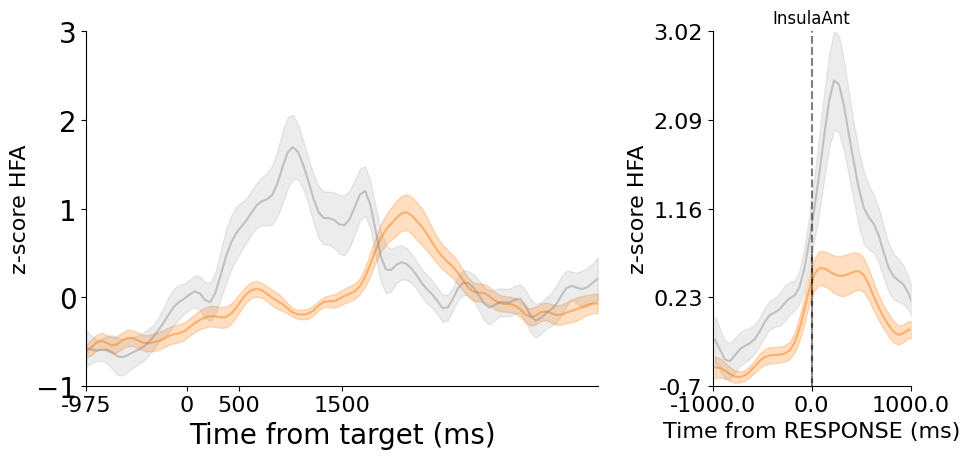

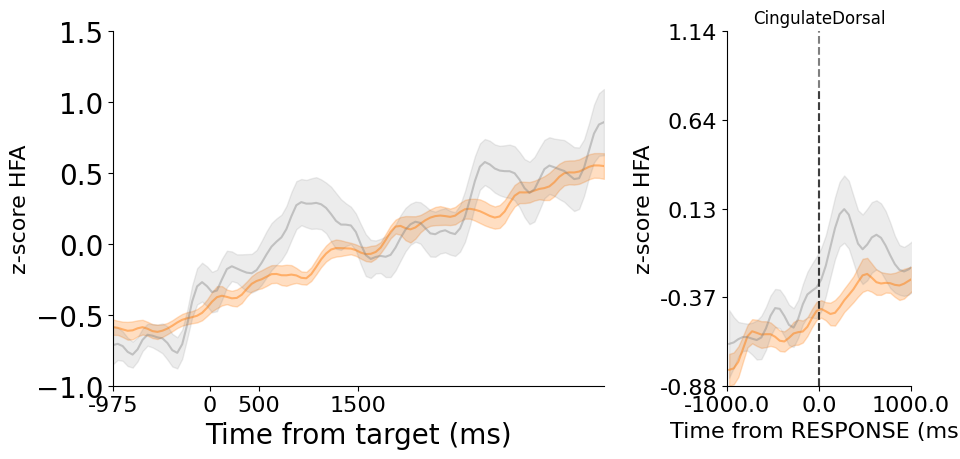

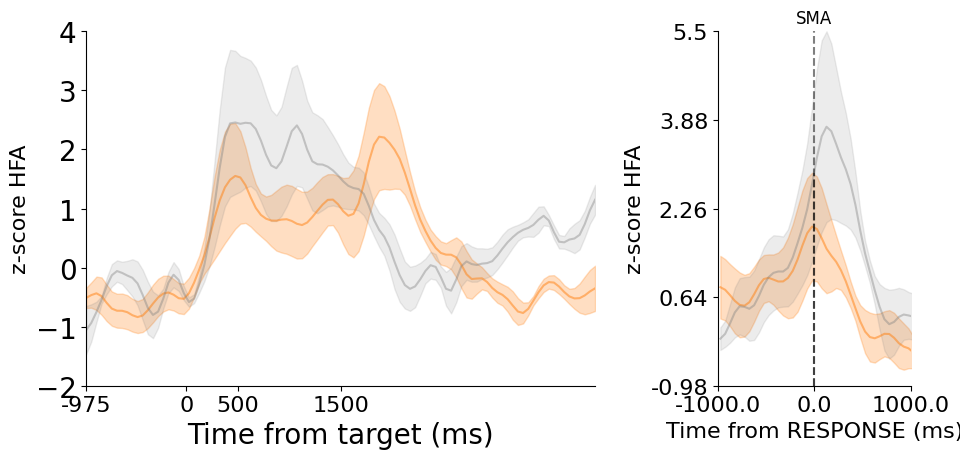

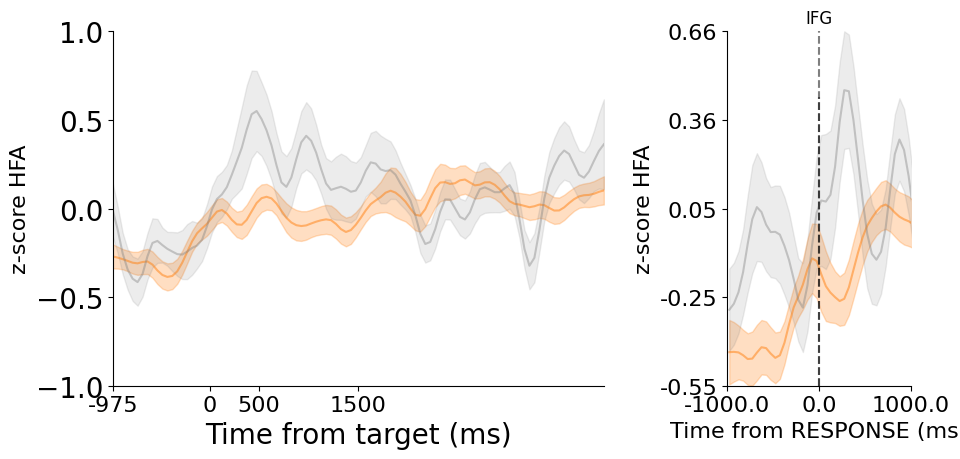

In [11]:
beh_feat = 'zrrtStoch'
# plot activation functions
for r in roiList_ant:
    print(r)
    ret_idx = (anatDf_ant.eval('roi=="'+r+'"'))
    #1) plot activation function (with peak times overlayed)
    ax_fix,ax_resp =plotActFunc(ret_idx,yL = None,beh_feat = beh_feat,lbl = None,\
        binByRT=False,show_false_alarms = True,delays_list=[1500],alphas_list=[.5,.5])
    plt.gca().set_title(r,fontsize=12)
    save_fig('ActFunc-ant-'+r)